In [3]:
import re
import string
import warnings
from pathlib import Path
from time import time

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import seaborn as sns
import src.common_data_processing as dphelp
from plotnine import aes, ggplot
from sklearn.manifold import TSNE

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

_ = gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

muted_red, muted_blue = "#e41a1c", "#377eb8"

## Data

In [2]:
data_path = Path("..", "modeling_data", "depmap_CRC_data.csv")
data = (
    pd.read_csv(data_path, low_memory=False)
    .sort_values(["lineage", "depmap_id", "hugo_symbol", "sgrna"])
    .reset_index(drop=True)
)


cat_columns = ["lineage", "depmap_id", "hugo_symbol"]
for col in cat_columns:
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data = data.fillna({"primary_or_metastasis": "unknown"})

## Visualization

Each cell line is marked as originating from a primary tumor, a metastasis, or the origin in unknown.
The distiributions of log-fold change (LFC) values do not seem to be very dependent upon this feature.

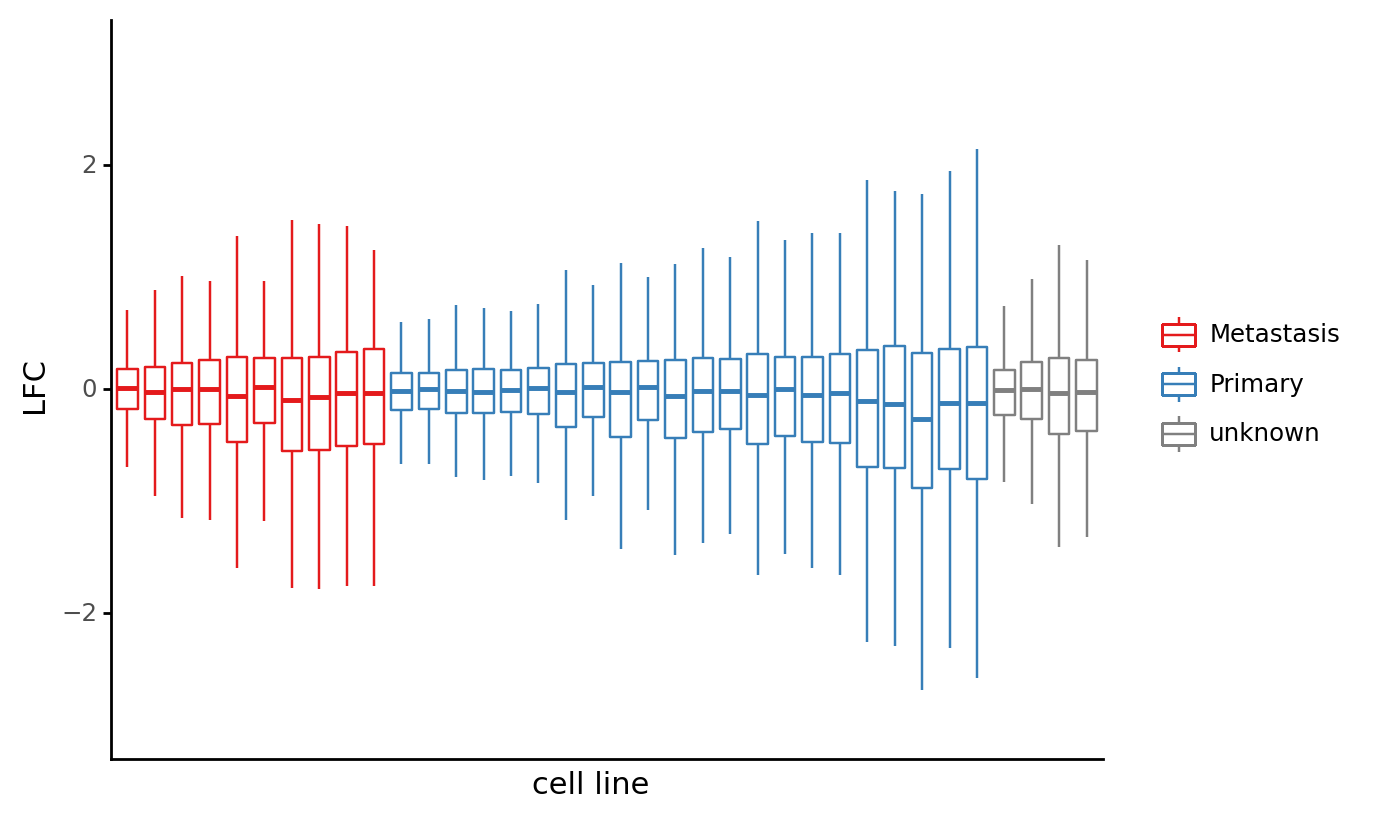

<ggplot: (8751642543336)>

In [3]:
prim_met_pal = (muted_red, muted_blue, "grey")

cell_line_order = (
    data.groupby("depmap_id")["lfc"]
    .agg(np.std)
    .reset_index()
    .merge(
        data[["depmap_id", "primary_or_metastasis"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    .sort_values(["primary_or_metastasis", "lfc"])[["depmap_id"]]
    .to_numpy()
    .flatten()
)

plot_data = data.copy().sample(frac=0.01).reset_index(drop=True)
plot_data["depmap_id"] = pd.Categorical(
    plot_data.depmap_id.values.tolist(), categories=cell_line_order, ordered=True
)

(
    ggplot(plot_data, aes(x="depmap_id", y="lfc"))
    + gg.geom_boxplot(aes(color="primary_or_metastasis"), outlier_alpha=0)
    + gg.scale_y_continuous(limits=(-3, 3))
    + gg.scale_color_manual(values=prim_met_pal)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        axis_ticks_major_x=gg.element_blank(),
        legend_title=gg.element_blank(),
    )
    + gg.labs(x="cell line", y="LFC")
)

There are some genes with far more variance in their LCF values and it seems to be negatively correlated with the average LFC for the gene. In other words, the more essential the gene tends to be, the more the values vary.

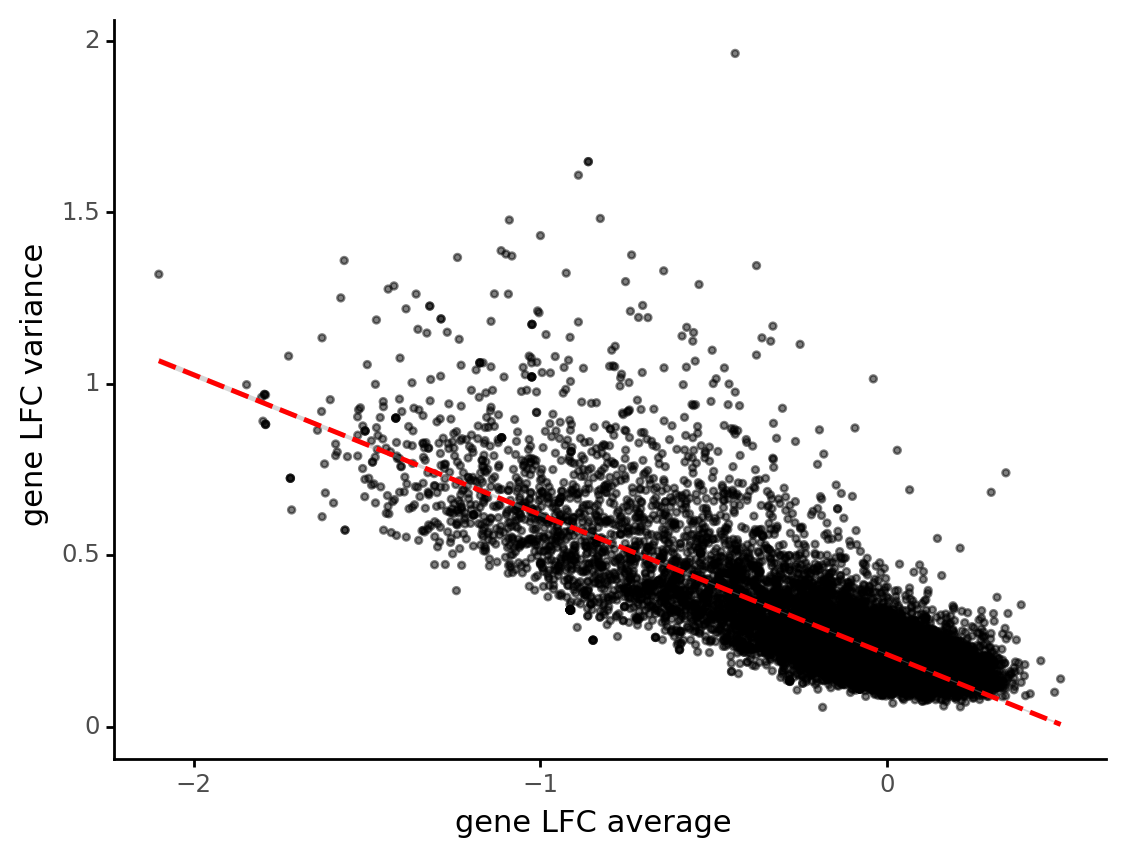

<ggplot: (8751692376769)>

In [4]:
gene_summary = data.groupby("hugo_symbol")["lfc"].agg([np.var, np.mean]).reset_index()
gene_summary = gene_summary.assign(
    label=lambda d: [
        n if np.abs(m) > 1.75 or v > 1.5 else np.nan
        for n, v, m in zip(d["hugo_symbol"], d["var"], d["mean"])
    ]
)

(
    ggplot(gene_summary, aes(x="mean", y="var"))
    + gg.geom_point(alpha=0.5, size=0.9)
    + gg.geom_smooth(color="red", method="lm", se=True, linetype="--")
    + gg.labs(x="gene LFC average", y="gene LFC variance")
)

In [5]:
def plot_line_against_lfc(
    df: pd.DataFrame, x: str, y: str = "lfc", alpha: float = 0.05, size: float = 0.7
) -> gg.ggplot:
    return (
        ggplot(df, aes(x=x, y=y))
        + gg.facet_wrap("depmap_id", ncol=3, scales="free_x")
        + gg.geom_point(size=size, alpha=alpha)
        + gg.geom_smooth(method="lm", se=True, color="red", linetype="--")
        + gg.theme(figure_size=(8, 25), subplots_adjust={"hspace": 0.4, "wspace": 0.1})
        + gg.labs(y="LFC")
    )

Interestingly, it does not seem like the CN of the gene is strongly correlated with the LFC for most genes.
For some genes there is a strong correlation, though there is not for most.

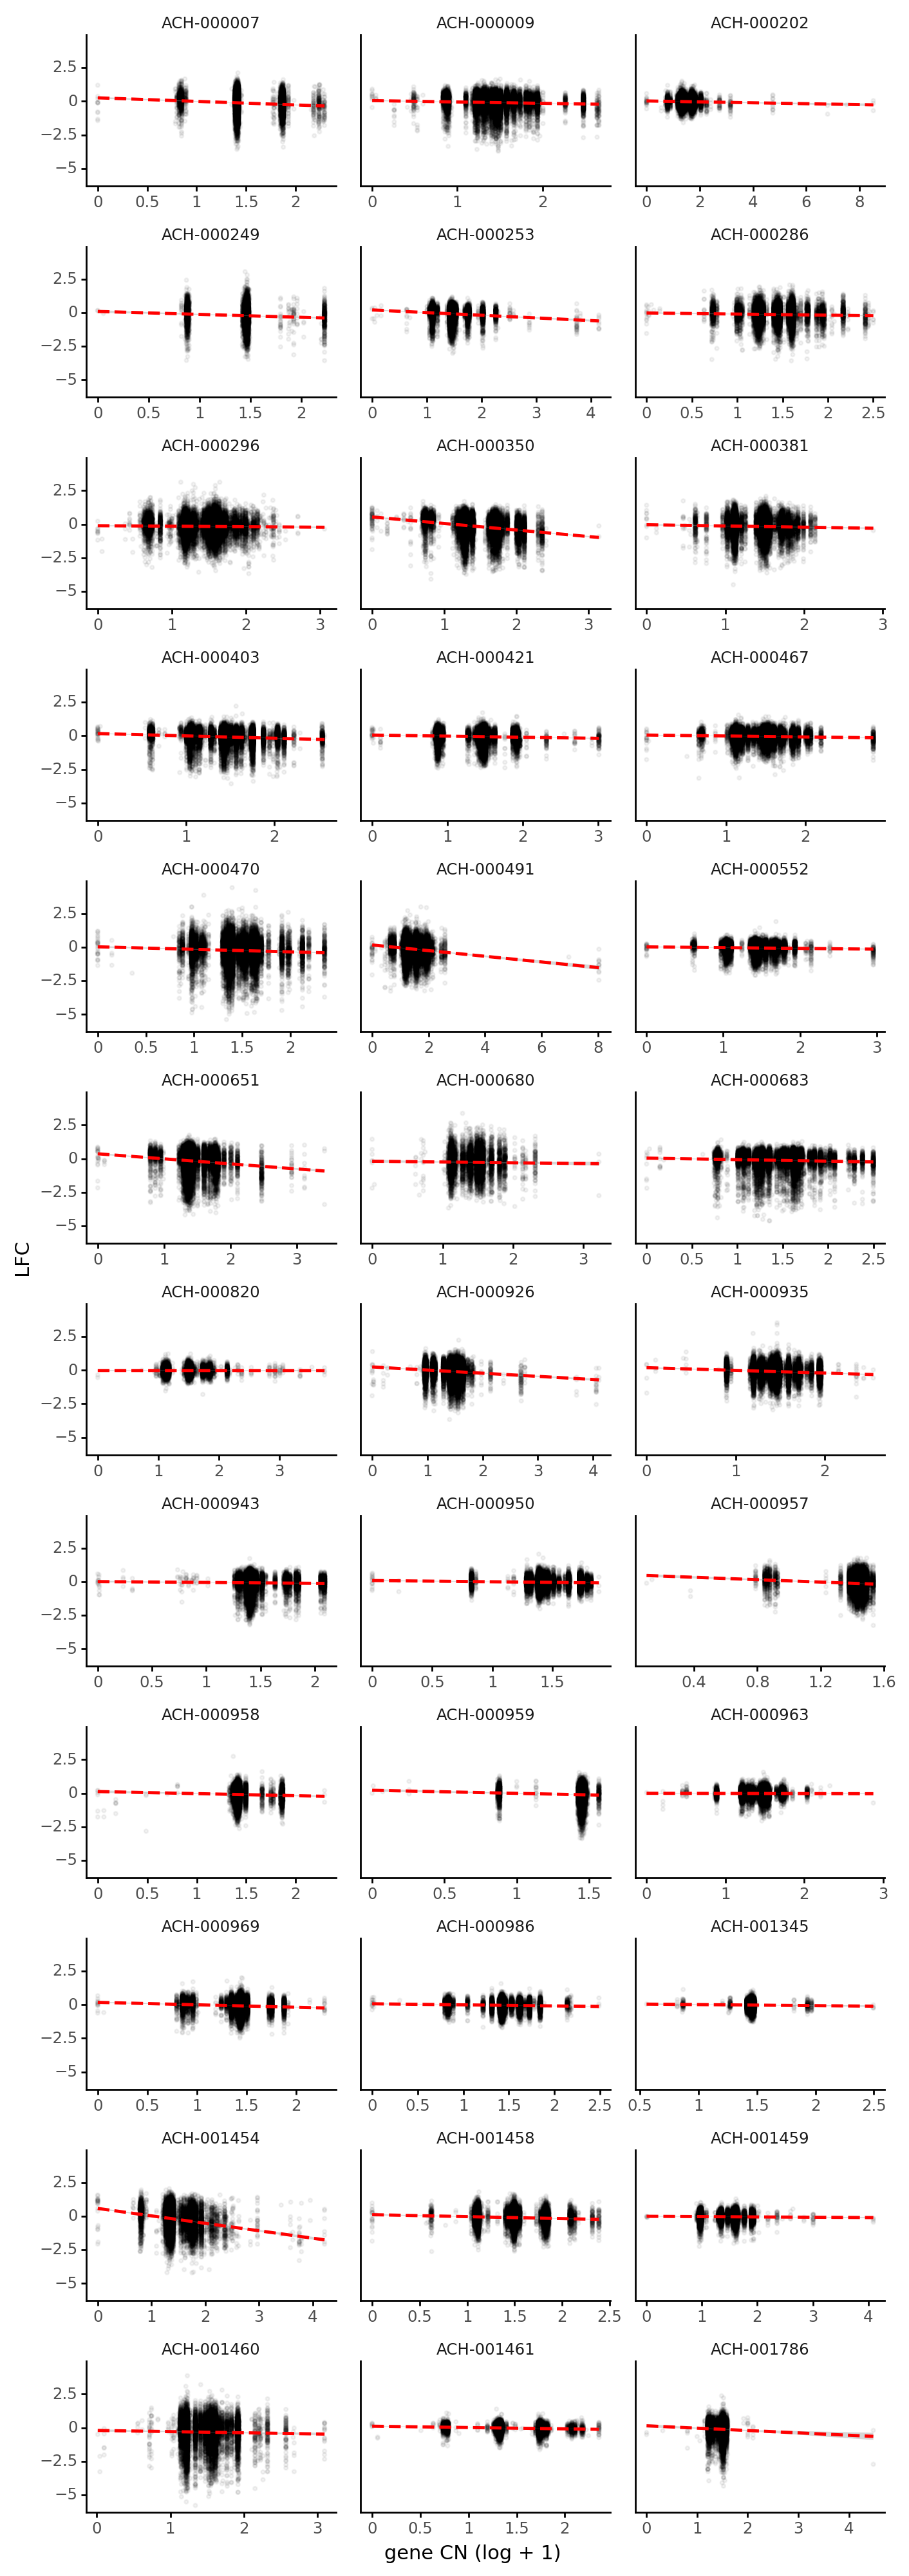

<ggplot: (8751641382660)>

In [6]:
plot_line_against_lfc(data.sample(frac=0.1), x="np.log2(gene_cn + 1)") + gg.labs(
    x="gene CN (log + 1)"
)

There is a similar story for the correlation between RNA expression of a gene and its LFC.

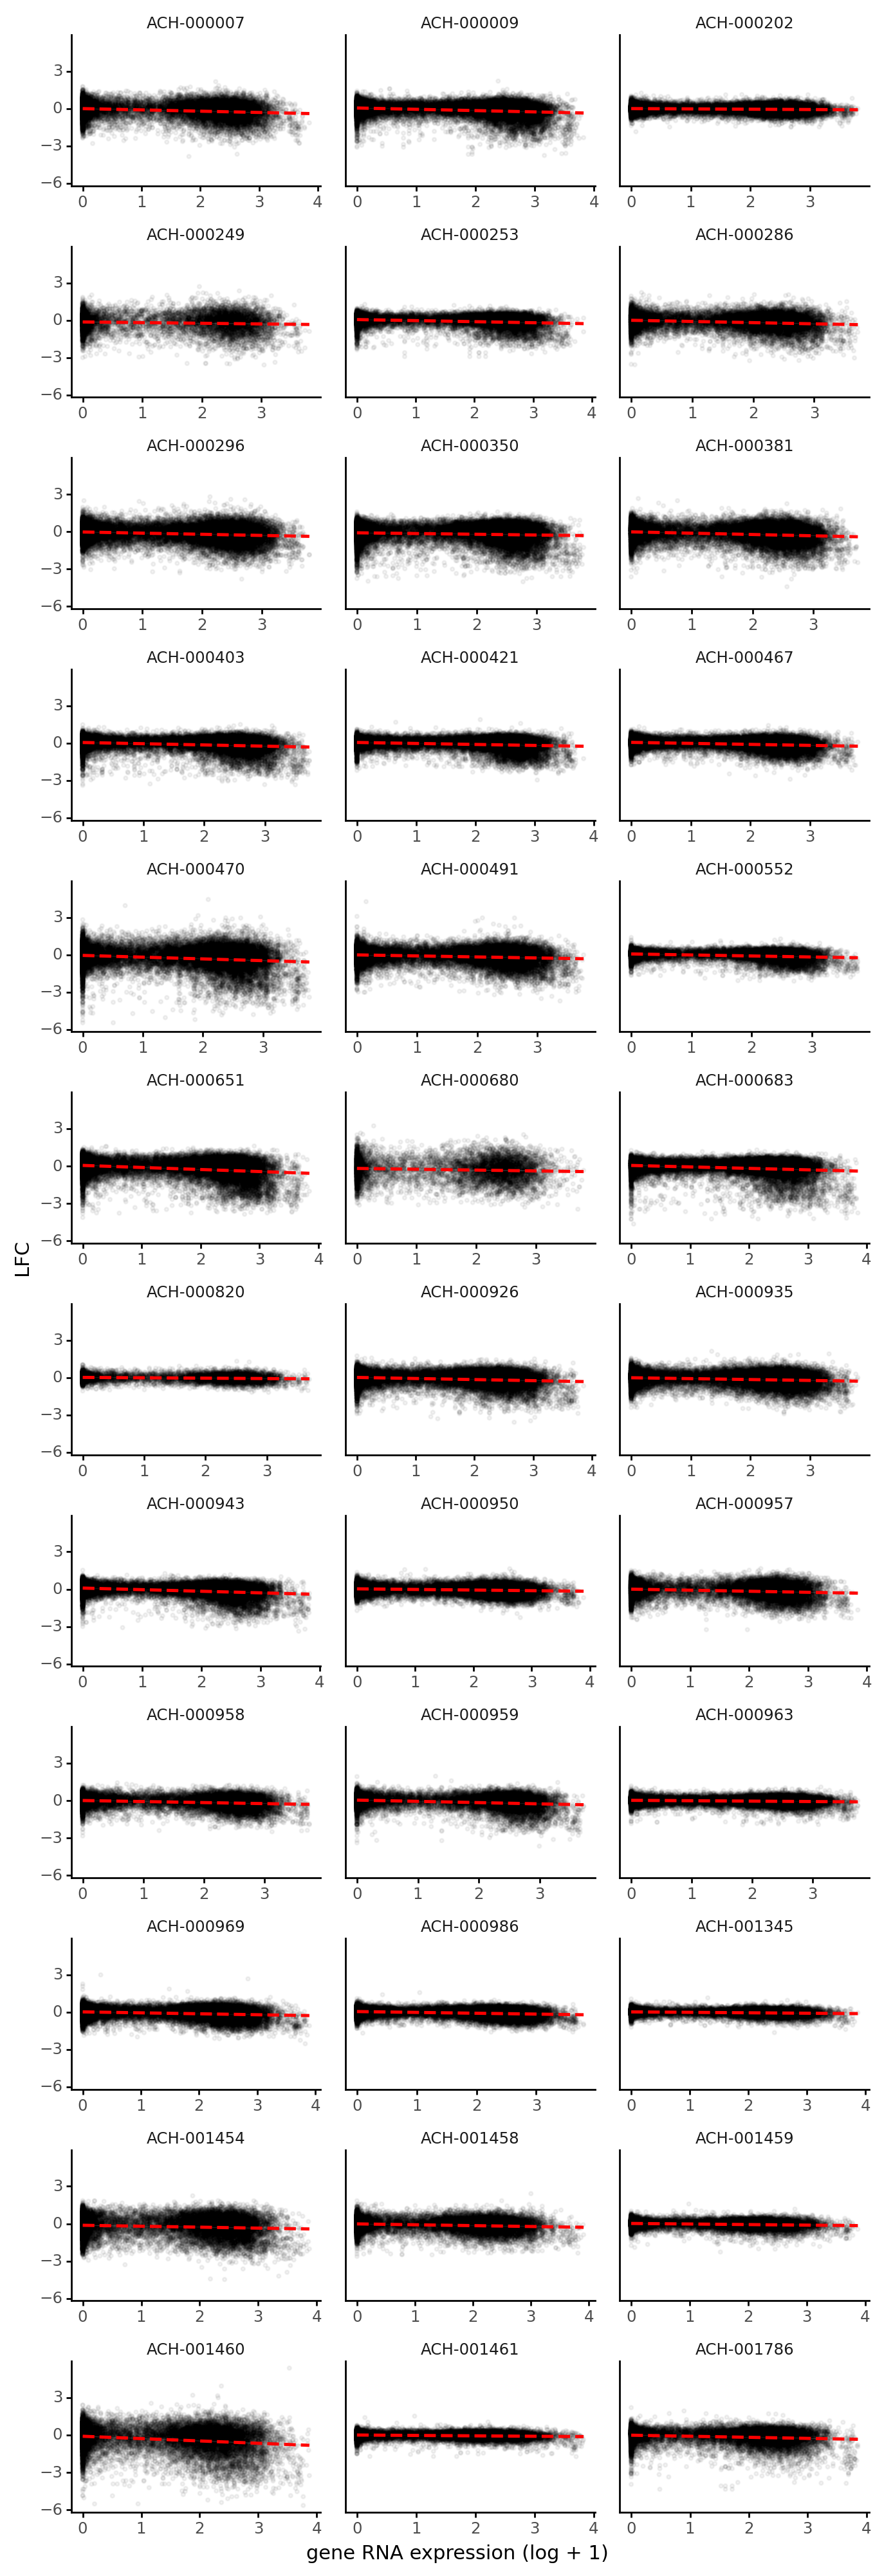

<ggplot: (8751564307622)>

In [7]:
plot_line_against_lfc(data.sample(frac=0.1), x="np.log2(rna_expr + 1)") + gg.labs(
    x="gene RNA expression (log + 1)"
)

The following plot shows the average and standard deviation LFC values for each chromosome (y) of each cell line (x).
There are some cell lines (e.g. ACH-001460) with much lower and more variable LFC values in general while others have an overage of 0 across all chromosomes.
Interestingly, there are also patterns across chromosomes, likely due to the specific genes that are on those chromosomes, not as a factor of chromosome size (since that decreases 1-22).

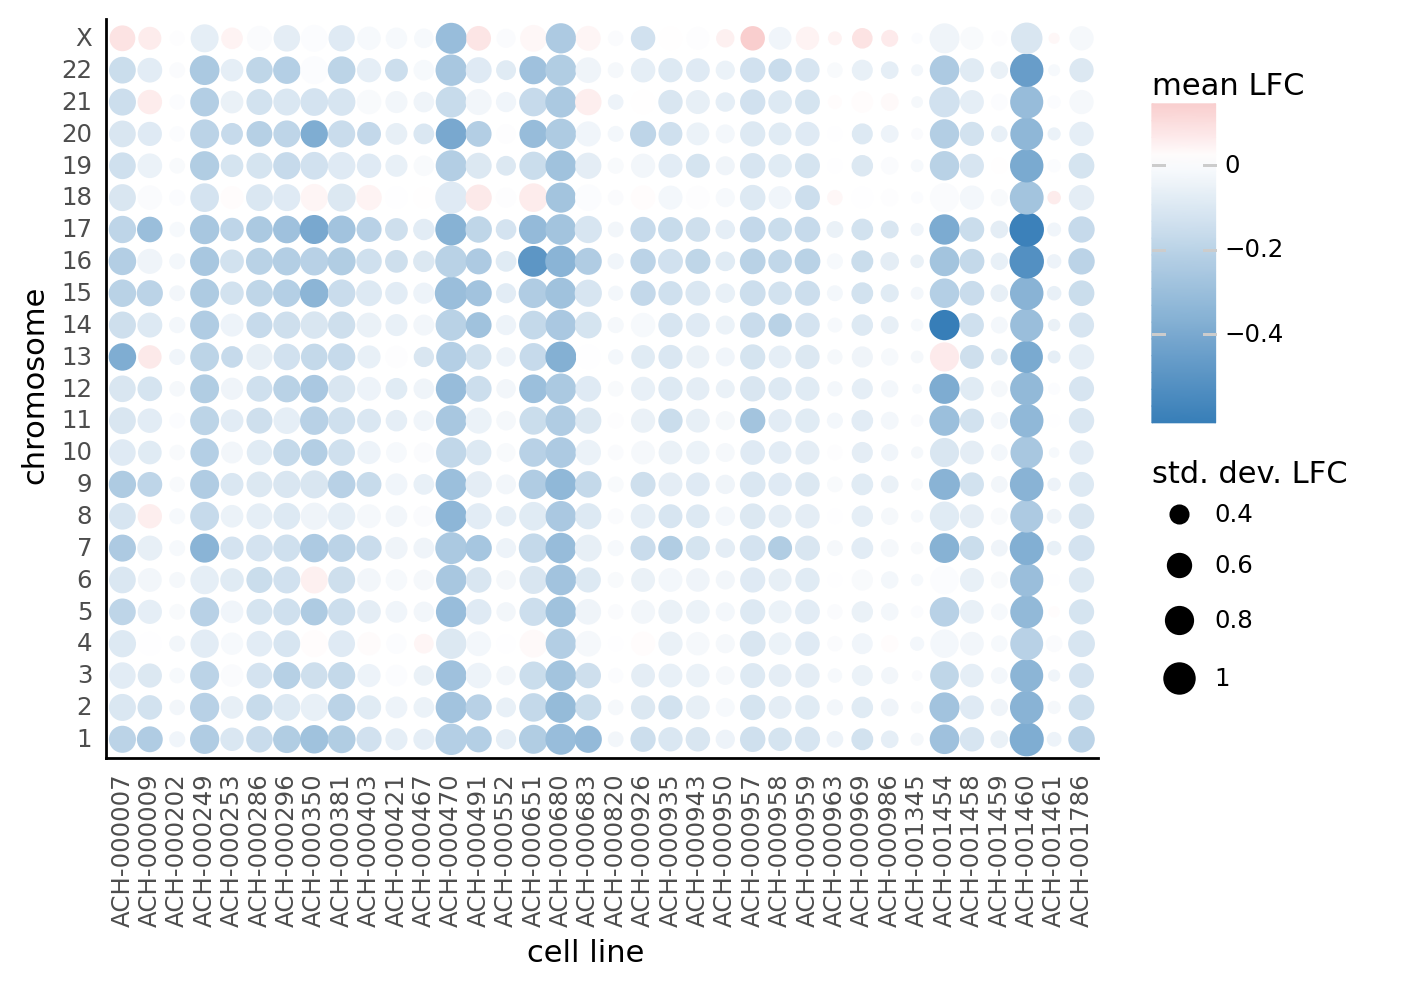

<ggplot: (8751638677685)>

In [8]:
chrom_order = [str(i) for i in range(1, 23)] + ["X"]

cell_chrom_summary = (
    data.groupby(["depmap_id", "chromosome"])["lfc"]
    .agg([np.mean, np.std])
    .reset_index()
)
cell_chrom_summary["chromosome"] = pd.Categorical(
    cell_chrom_summary.chromosome, categories=chrom_order, ordered=True
)

(
    ggplot(cell_chrom_summary, aes(x="depmap_id", y="chromosome"))
    + gg.geom_point(aes(color="mean", size="std"))
    + gg.scale_color_gradient2(low=muted_blue, mid="white", high=muted_red, midpoint=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90),
        axis_ticks_major_x=gg.element_blank(),
        axis_ticks_major_y=gg.element_blank(),
    )
    + gg.labs(x="cell line", y="chromosome", color="mean LFC", size="std. dev. LFC")
)

I tried to identify clusters in the cell lines using t-SNE, but nothing is apparent, even after limiting the analysis to the top 99% most variable genes.

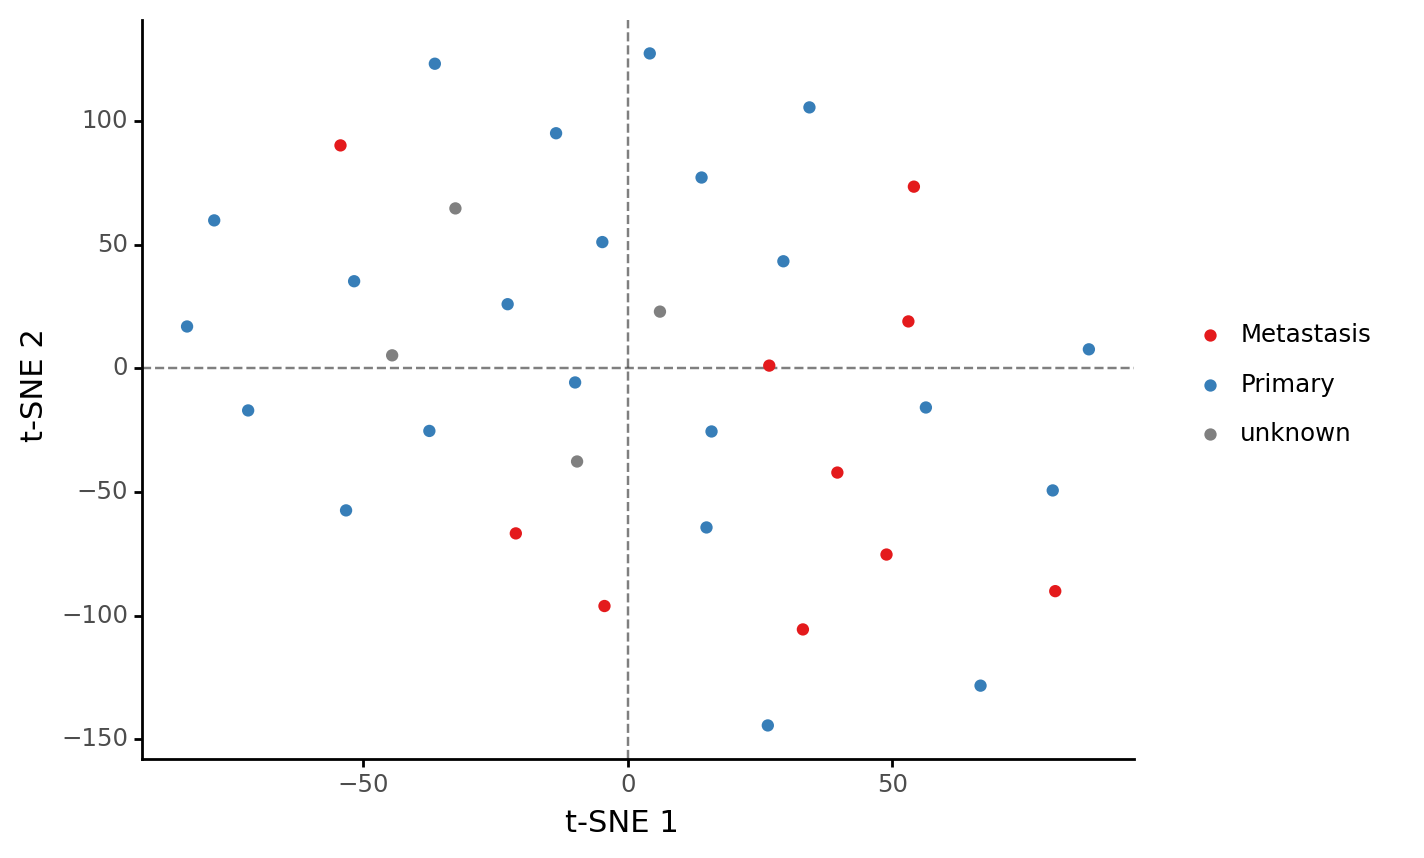

<ggplot: (8751564411615)>

In [9]:
X = (
    data.groupby(["depmap_id", "hugo_symbol"])["lfc"]
    .agg(np.mean)
    .reset_index()
    .pivot("depmap_id", "hugo_symbol", "lfc")
)

gene_var = X.to_numpy().var(axis=0)
top_percentile_var = np.percentile(gene_var, 99)
gene_idx = gene_var >= top_percentile_var

X_embedded = TSNE(n_components=2, init="pca", random_state=RANDOM_SEED).fit_transform(
    X.to_numpy()[:, gene_idx]
)
tsne_res = pd.DataFrame(X_embedded, columns=("x1", "x2")).assign(
    depmap_id=X.index.values.to_numpy()
)
tsne_res = tsne_res.merge(
    data[["depmap_id", "primary_or_metastasis"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

(
    ggplot(tsne_res, aes("x1", "x2"))
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_vline(xintercept=0, alpha=0.5, linetype="--")
    + gg.geom_point(aes(color="primary_or_metastasis"))
    + gg.scale_color_manual(values=prim_met_pal)
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x="t-SNE 1", y="t-SNE 2")
)

Finally, there does not seem to be an obvious batch-effect according to the pDNA batch the cell line was transfected with.

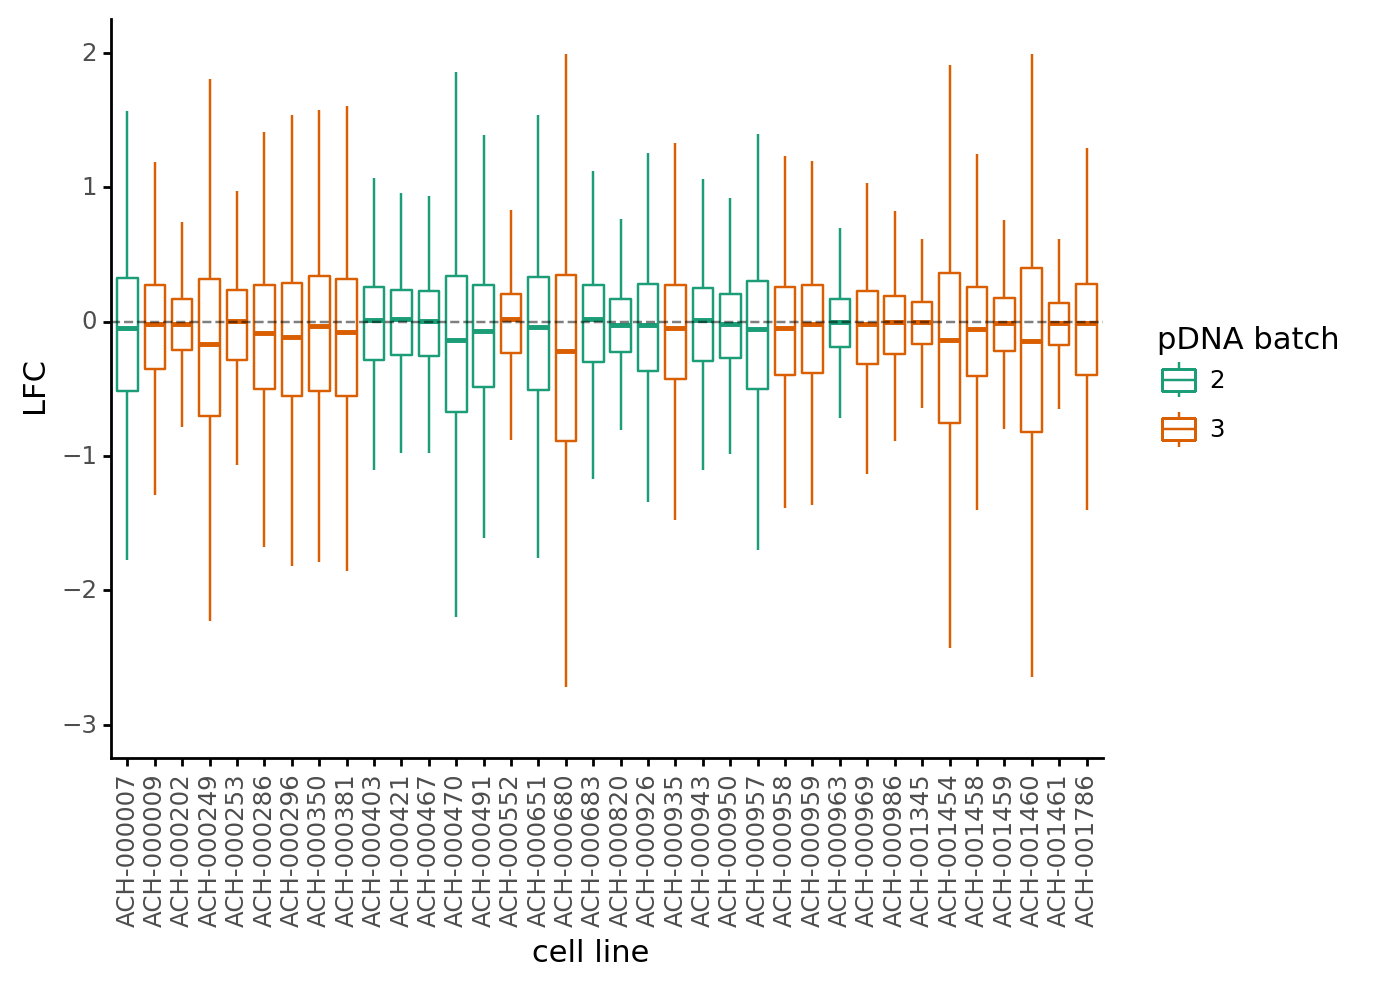

<ggplot: (8751564362147)>

In [10]:
(
    ggplot(data.sample(frac=0.05), aes(x="depmap_id", y="lfc"))
    + gg.geom_boxplot(aes(color="factor(pdna_batch)"), outlier_alpha=0)
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.scale_y_continuous(limits=(-3, 2))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x="cell line", y="LFC", color="pDNA batch")
)

---

In [11]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.12 minutes


In [12]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-16

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: crc

matplotlib: 3.3.4
seaborn   : 0.11.1
numpy     : 1.20.1
re        : 2.2.1
plotnine  : 0.7.1
pandas    : 1.2.2

